# LINEAR REGRESSION

In [1]:
# basics
import os, sys
import progressbar

# arrays
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# append sscode to path
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

# data viewer
from sscode.config import data_path
from sscode.data import Loader, load_moana_hindcast_ss
from sscode.pca import PCA_DynamicPred
from sscode.cca import CCA_Analysis
from sscode.linear import MultiLinear_Regression
from sscode.plotting.utils import plot_ccrs_nz

# warnings
import warnings
warnings.filterwarnings('ignore')

## load the data


 loading the sea-level-pressure fields... 


 loading daily resampled data... 



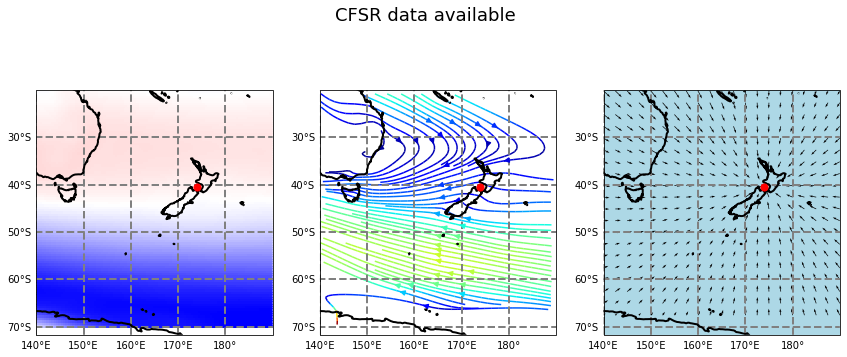


 loading the Moana v2 hindcast data... 



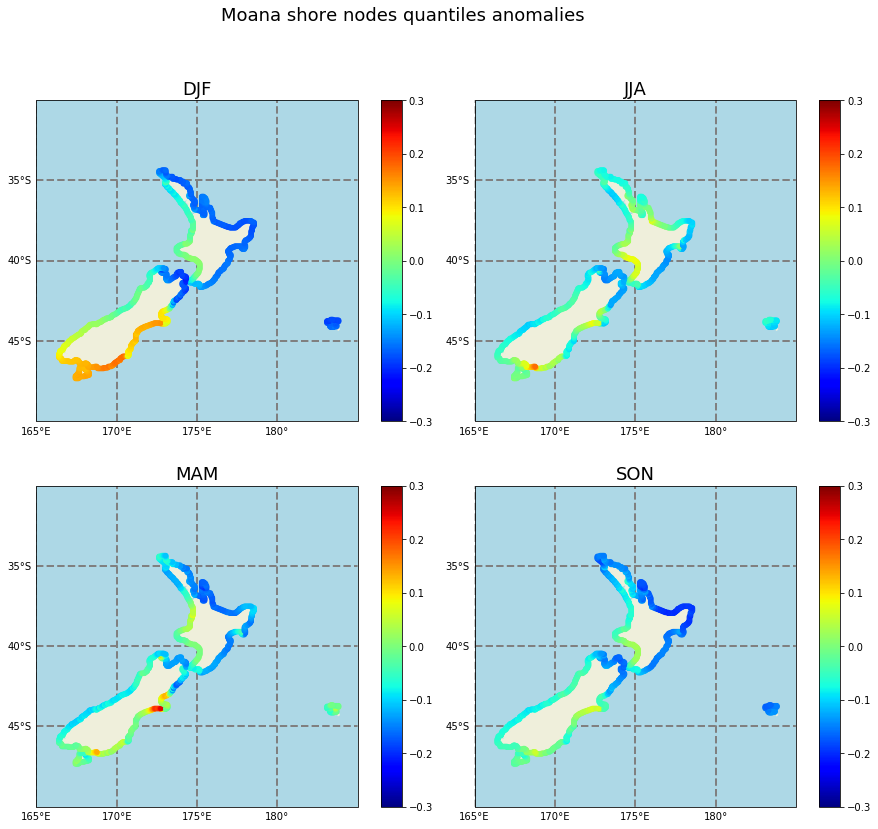


 loading and plotting the UHSLC tidal guages... 



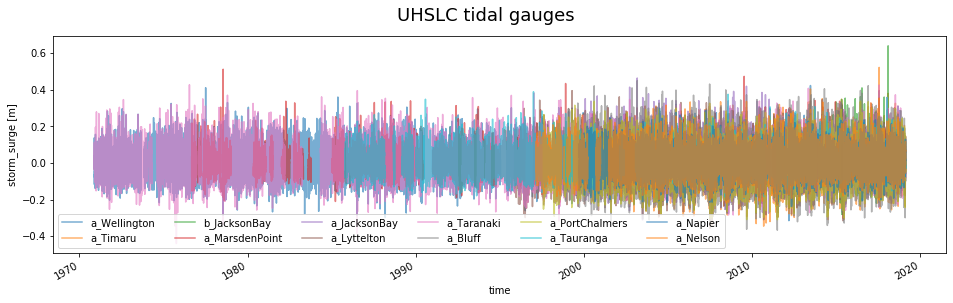

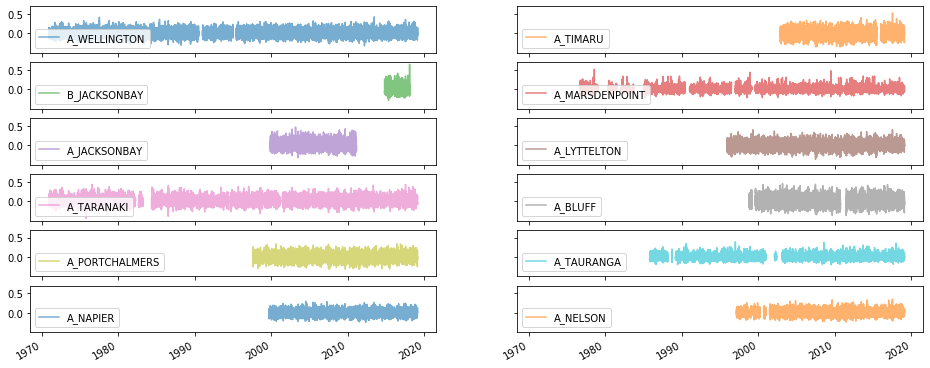

In [2]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc']
)

In [3]:
load_cfsr_moana_uhslc.location

(173.9, -40.5)

## load / calculate the pcs


 plotting 3 components with 2 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



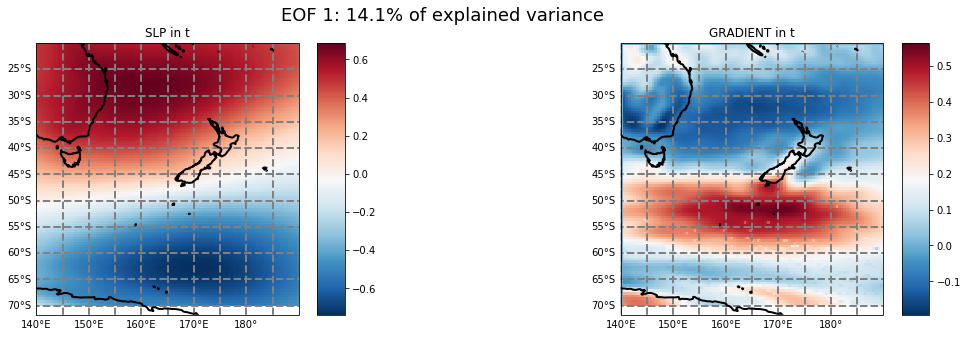

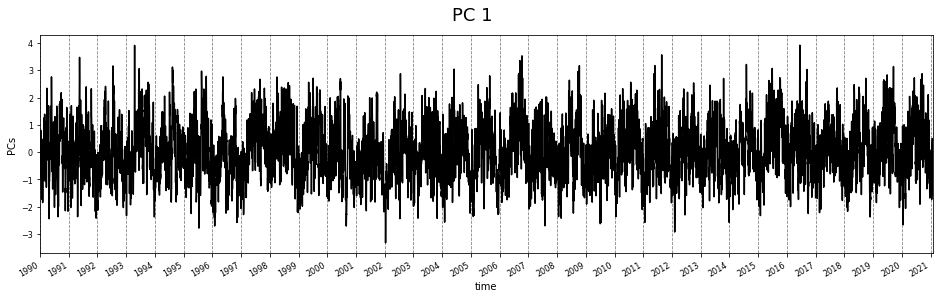

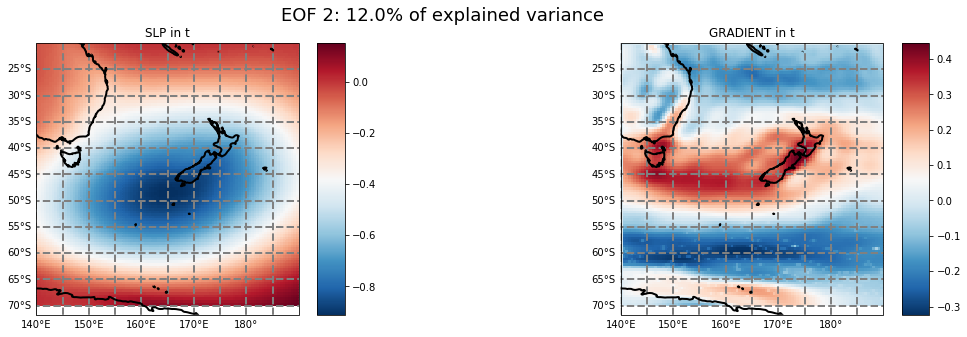

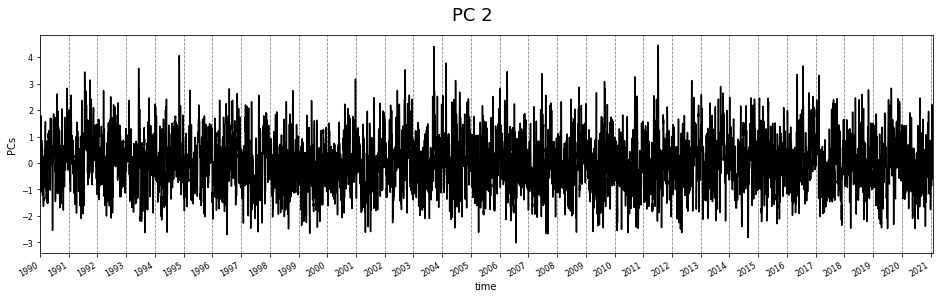

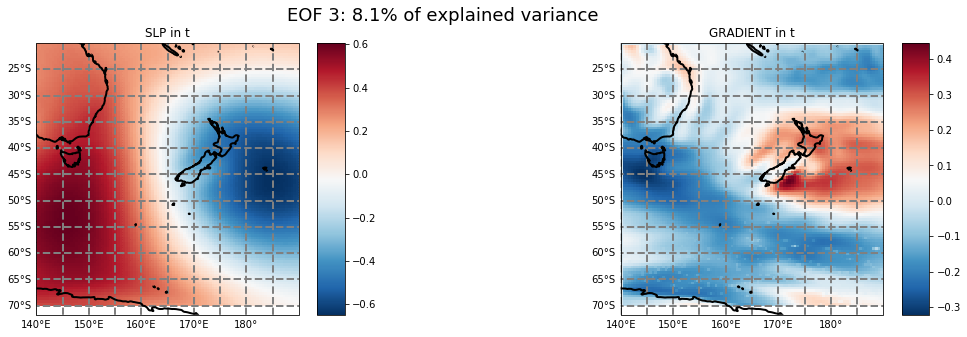

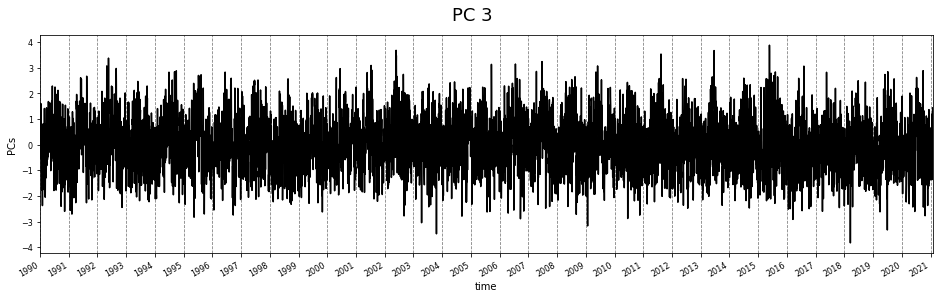

In [4]:
# load / calculate the pcs
if os.path.isfile('../data/cfsr/cfsr_regional_daily_pcs.nc'):
    pcs_cfsr = xr.open_dataset(
        '../data/cfsr/cfsr_regional_daily_pcs.nc'
    )
    from sscode.plotting.pca import plot_pcs
    plot_pcs(pcs_cfsr,n_plot=3)
else:
    # calculate the pcs
    pcs_cfsr, pcs_scaler = PCA_DynamicPred(
        load_cfsr_moana_uhslc.predictor_slp\
            .sel(time=slice('1990','2010')),
        # pres_vars=('wind_proj','lon','lat'),
        calculate_gradient=True,
        winds=(True,load_cfsr_moana_uhslc.predictor_wind),
        region=(True,(
            load_cfsr_moana_uhslc.location[0]-2.1,
            load_cfsr_moana_uhslc.location[0]+2.1,
            load_cfsr_moana_uhslc.location[1]+2.1,
            load_cfsr_moana_uhslc.location[1]-2.1
        )),
        time_lapse=2, # 1 equals to NO time delay 
        time_resample='1D',
        pca_plot=True
    )

## linear regression with regional predictor

In [5]:
run = False
if run:
    # perform the Multilinear-Regression (regional)
    stats_regional = []
    sites_regional = np.arange(
        0,len(load_cfsr_moana_uhslc.predictand.site.values),5
    )
    for stat in progressbar.progressbar(sites_regional):
        ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
            .load().resample(time='1D').max()
        stats_stat = MultiLinear_Regression(
            pcs_cfsr, ss_moana, verbose=False
        ) # pre-loaded pcs
        stats_regional.append(stats_stat)
    # save the statistics
    stats_regional = xr.Dataset(
        data_vars={
            'bias':(('station'),np.array(stats_regional)[:,0]),
            'si':(('station'),np.array(stats_regional)[:,1]),
            'rmse':(('station'),np.array(stats_regional)[:,2]),
            'pearson':(('station'),np.array(stats_regional)[:,3]),
            'spearman':(('station'),np.array(stats_regional)[:,4]),
            'rscore':(('station'),np.array(stats_regional)[:,5]),
            'latitude':(('station'),
                load_cfsr_moana_uhslc.predictand.sel(site=sites_regional).lat),
            'longitude':(('station'),
                load_cfsr_moana_uhslc.predictand.sel(site=sites_regional).lon)
        },
        coords={
            'station': sites_regional
        }
    )
    # local copy
    if True:
        stats_regional.to_netcdf(data_path+'/statistics/stats_lm_regional_daily.nc')
else:
    stats_regional = xr.open_dataset(
        data_path+'/statistics/stats_lm_regional_daily.nc'
    )

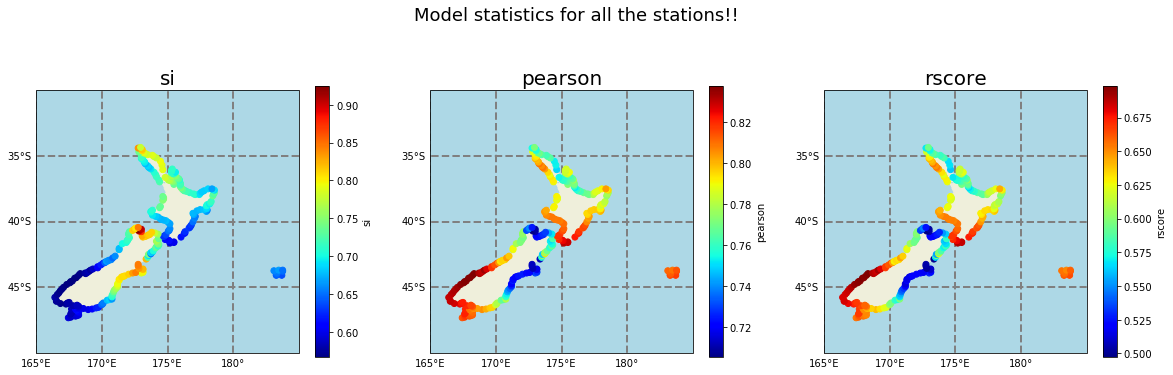

In [6]:
# plot results
if True:
    from sscode.plotting.validation import plot_stats
    plot_stats(stats_regional,plot_stats=['si','pearson','rscore'])


 72 PCs (0.9 expl. variance) will be used to train the model!! 



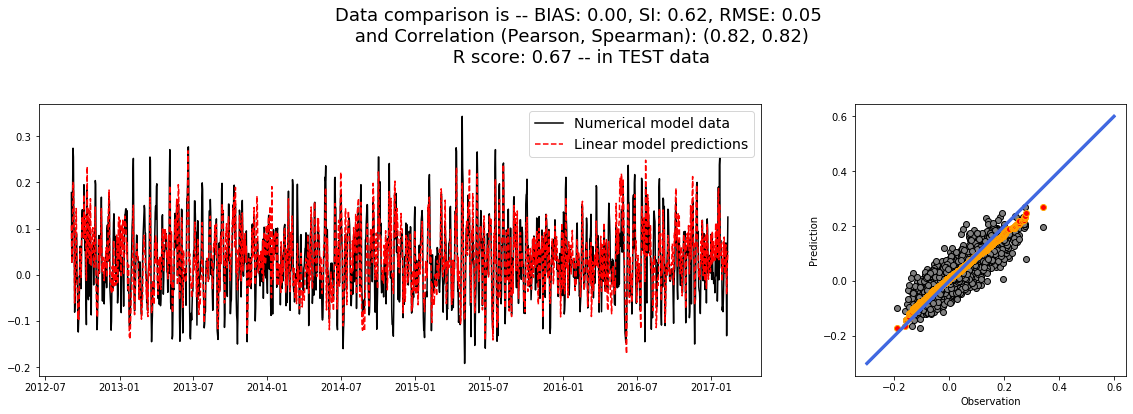

Data comparison is -- BIAS: 0.00, SI: 0.62, RMSE: 0.05
 and Correlation (Pearson, Spearman): (0.82, 0.82)
 R score: 0.67 -- in TEST data


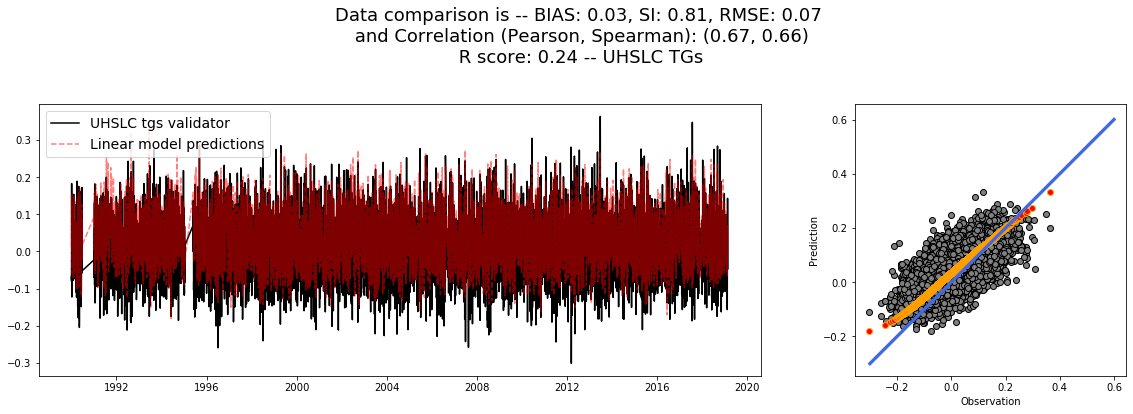


 72 PCs (0.9 expl. variance) will be used to train the model!! 



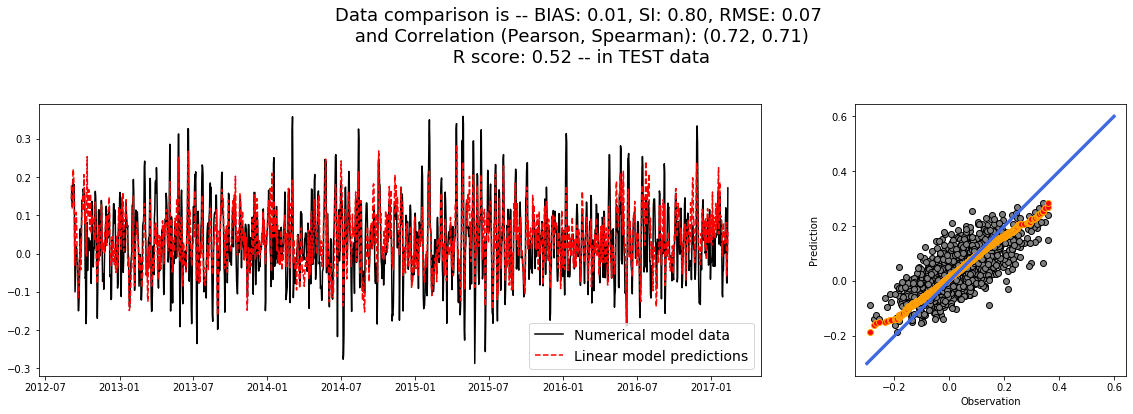

Data comparison is -- BIAS: 0.01, SI: 0.80, RMSE: 0.07
 and Correlation (Pearson, Spearman): (0.72, 0.71)
 R score: 0.52 -- in TEST data


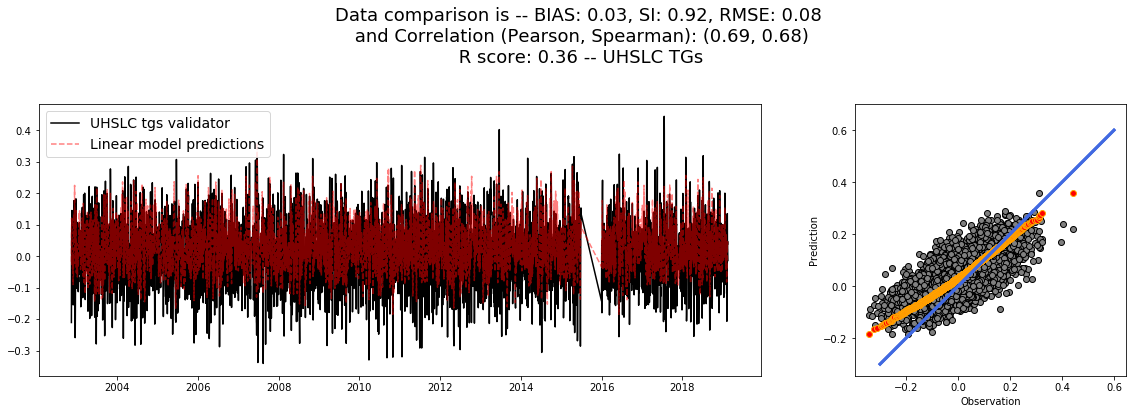


 72 PCs (0.9 expl. variance) will be used to train the model!! 



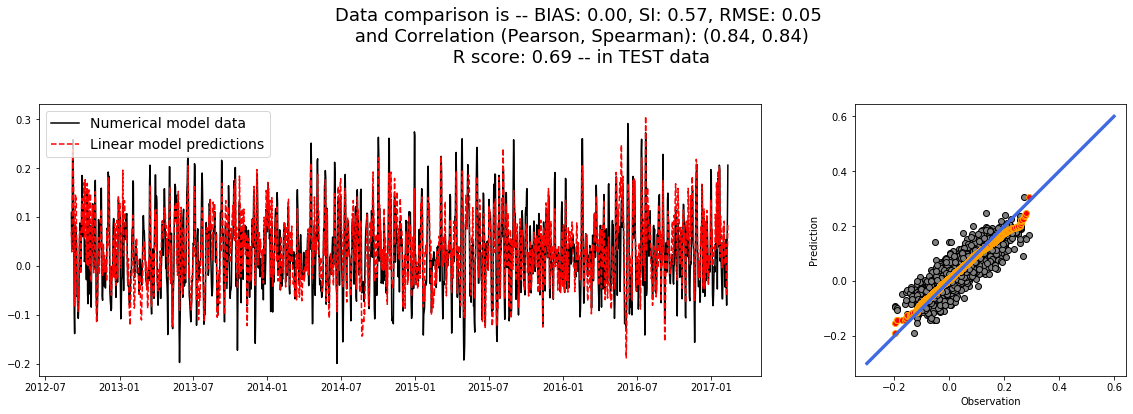

Data comparison is -- BIAS: 0.00, SI: 0.57, RMSE: 0.05
 and Correlation (Pearson, Spearman): (0.84, 0.84)
 R score: 0.69 -- in TEST data


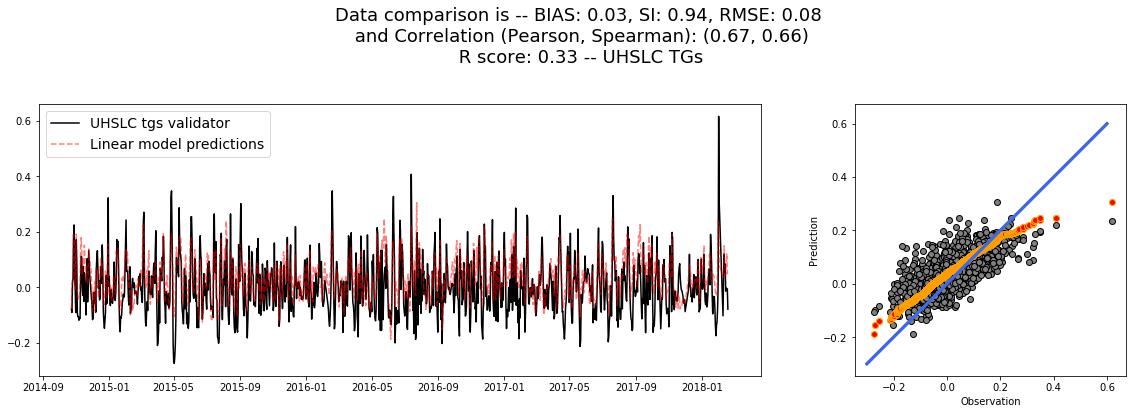


 72 PCs (0.9 expl. variance) will be used to train the model!! 



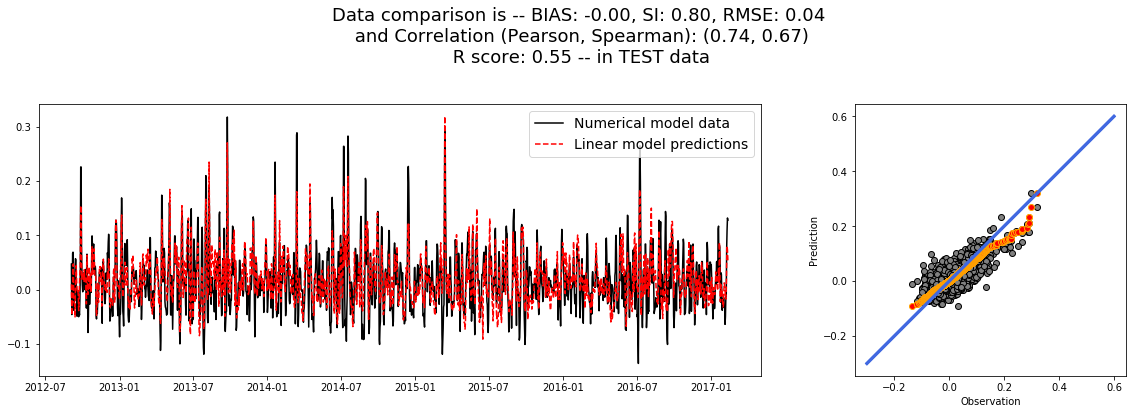

Data comparison is -- BIAS: -0.00, SI: 0.80, RMSE: 0.04
 and Correlation (Pearson, Spearman): (0.74, 0.67)
 R score: 0.55 -- in TEST data


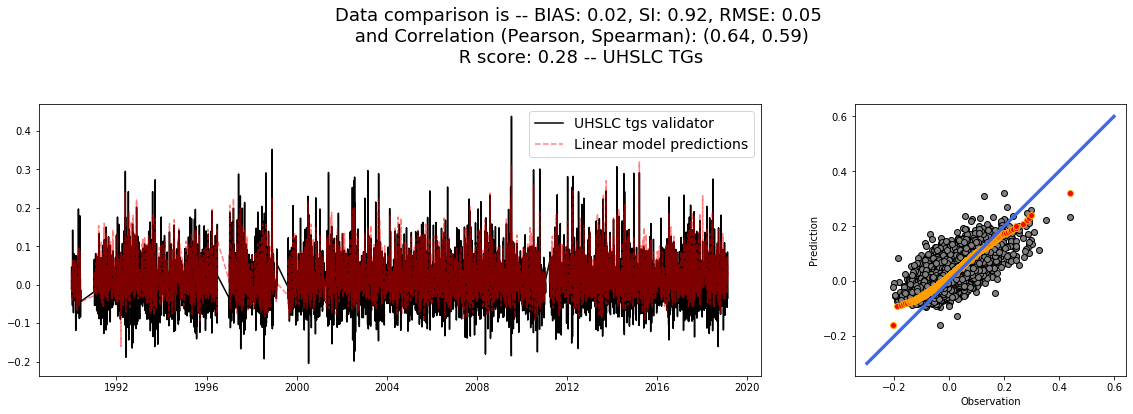


 72 PCs (0.9 expl. variance) will be used to train the model!! 



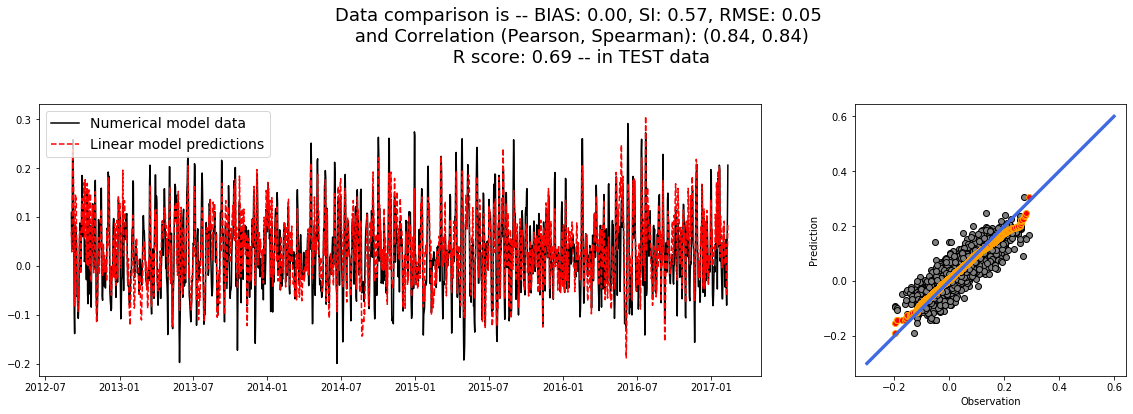

Data comparison is -- BIAS: 0.00, SI: 0.57, RMSE: 0.05
 and Correlation (Pearson, Spearman): (0.84, 0.84)
 R score: 0.69 -- in TEST data


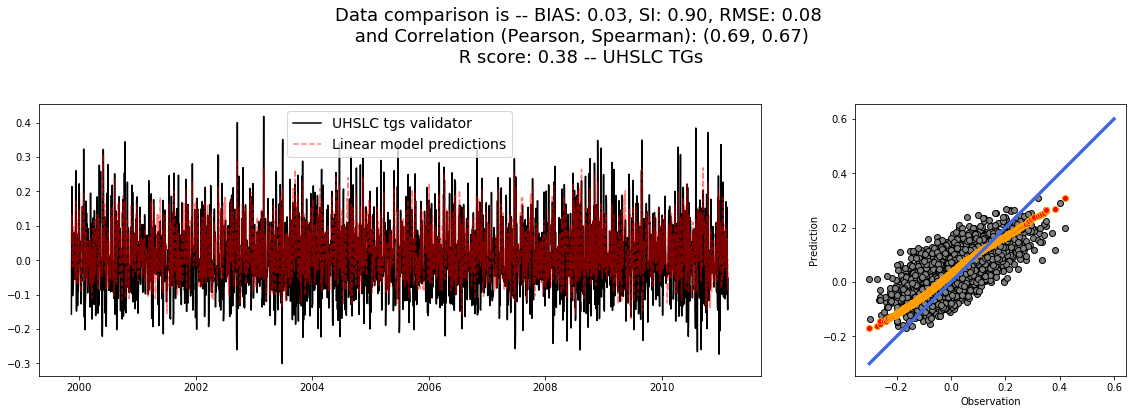


 72 PCs (0.9 expl. variance) will be used to train the model!! 



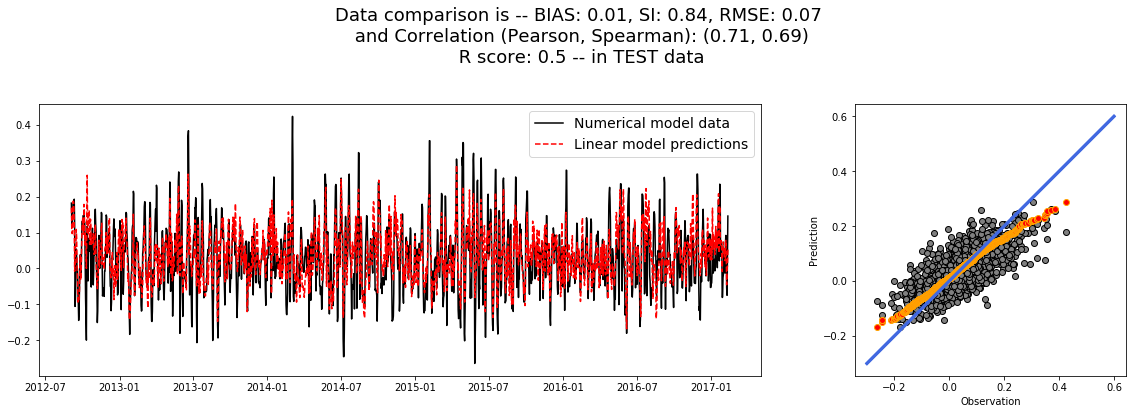

Data comparison is -- BIAS: 0.01, SI: 0.84, RMSE: 0.07
 and Correlation (Pearson, Spearman): (0.71, 0.69)
 R score: 0.5 -- in TEST data


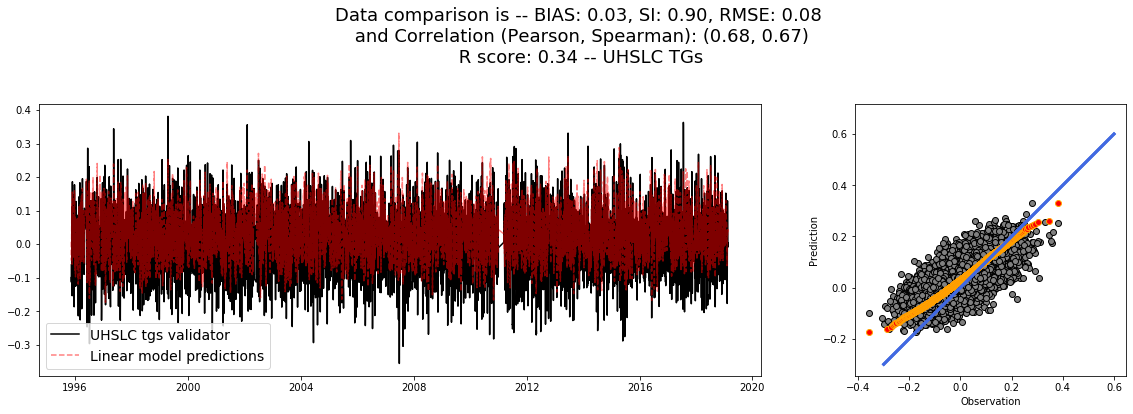


 72 PCs (0.9 expl. variance) will be used to train the model!! 



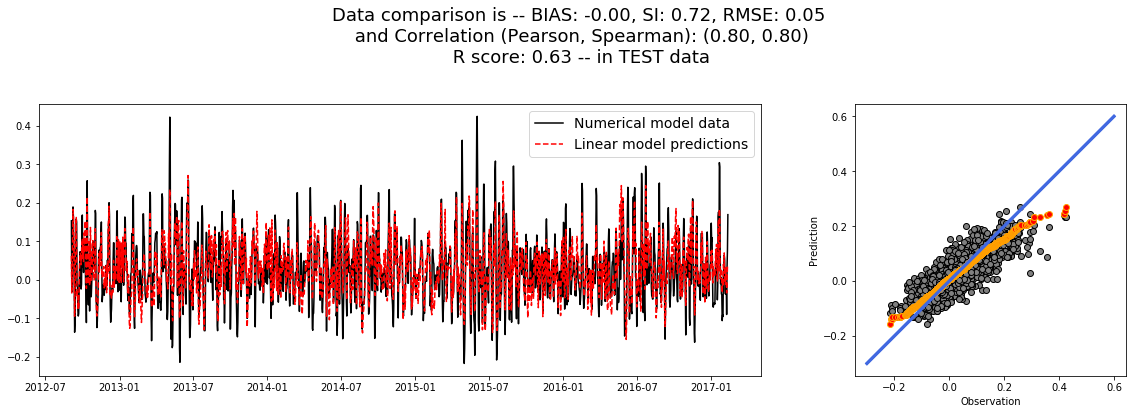

Data comparison is -- BIAS: -0.00, SI: 0.72, RMSE: 0.05
 and Correlation (Pearson, Spearman): (0.80, 0.80)
 R score: 0.63 -- in TEST data


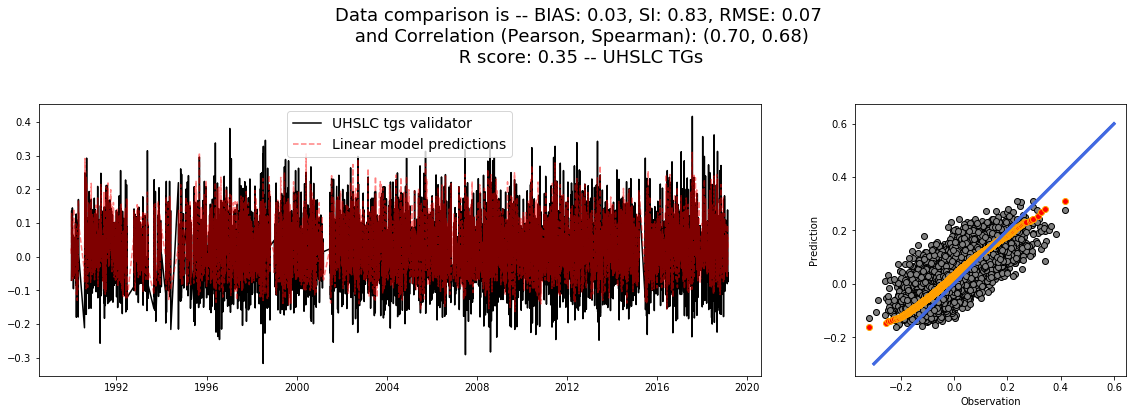


 72 PCs (0.9 expl. variance) will be used to train the model!! 



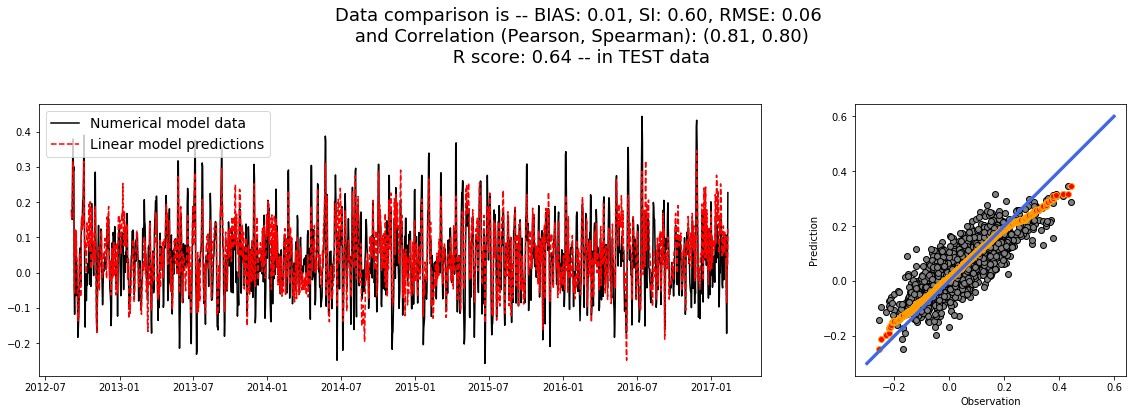

Data comparison is -- BIAS: 0.01, SI: 0.60, RMSE: 0.06
 and Correlation (Pearson, Spearman): (0.81, 0.80)
 R score: 0.64 -- in TEST data


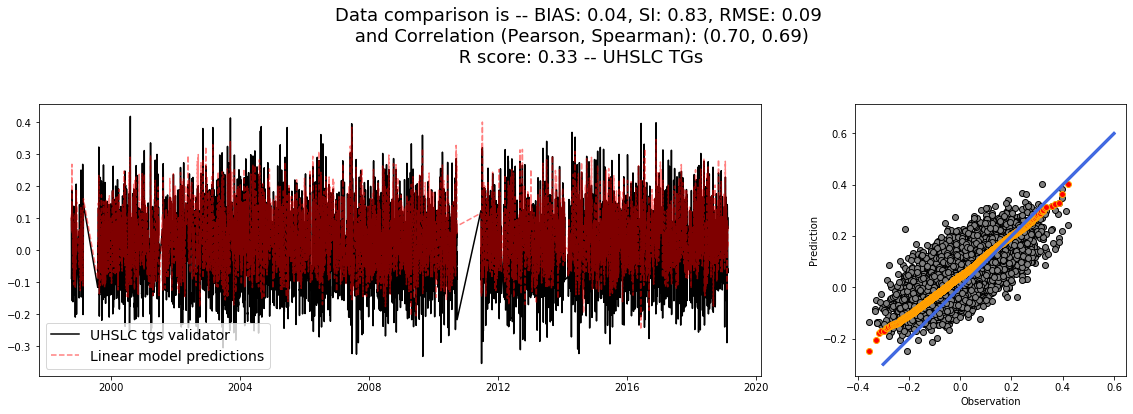


 72 PCs (0.9 expl. variance) will be used to train the model!! 



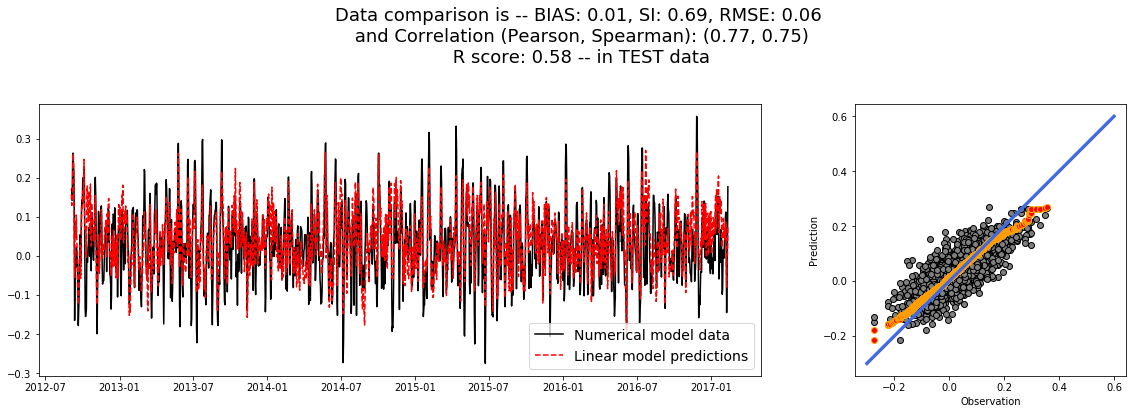

Data comparison is -- BIAS: 0.01, SI: 0.69, RMSE: 0.06
 and Correlation (Pearson, Spearman): (0.77, 0.75)
 R score: 0.58 -- in TEST data


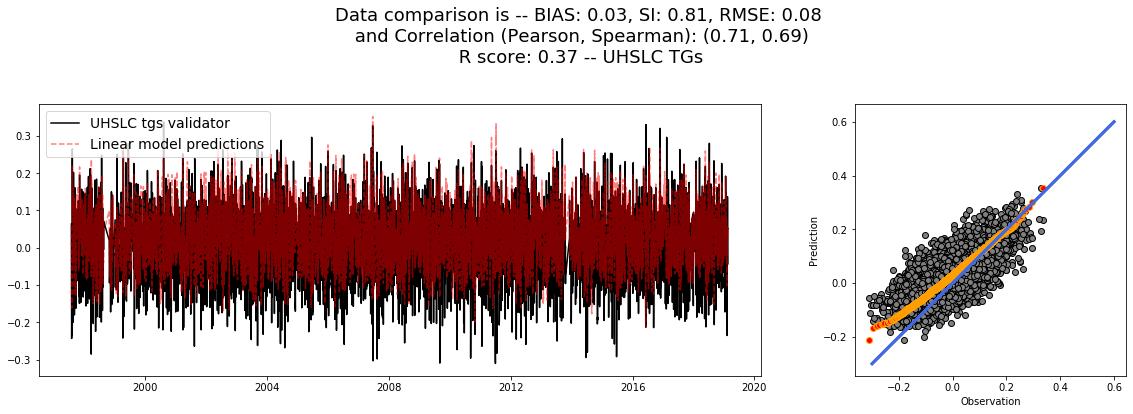


 72 PCs (0.9 expl. variance) will be used to train the model!! 



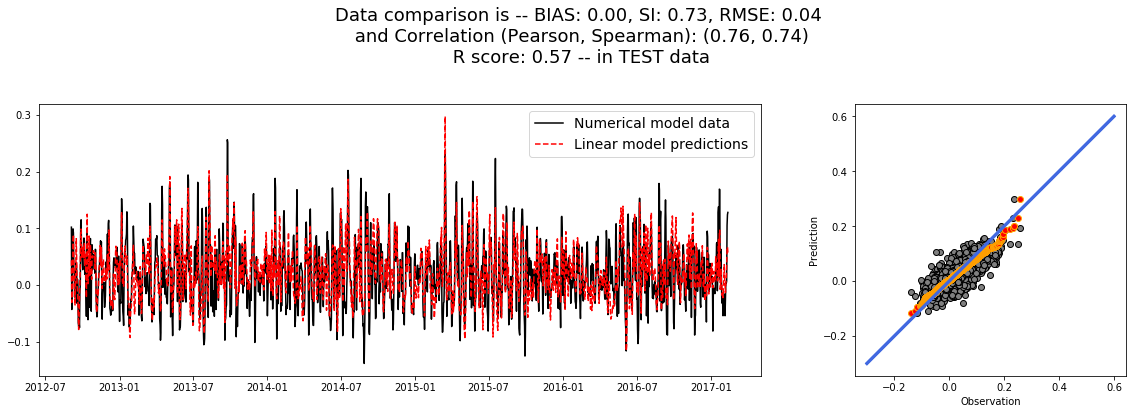

Data comparison is -- BIAS: 0.00, SI: 0.73, RMSE: 0.04
 and Correlation (Pearson, Spearman): (0.76, 0.74)
 R score: 0.57 -- in TEST data


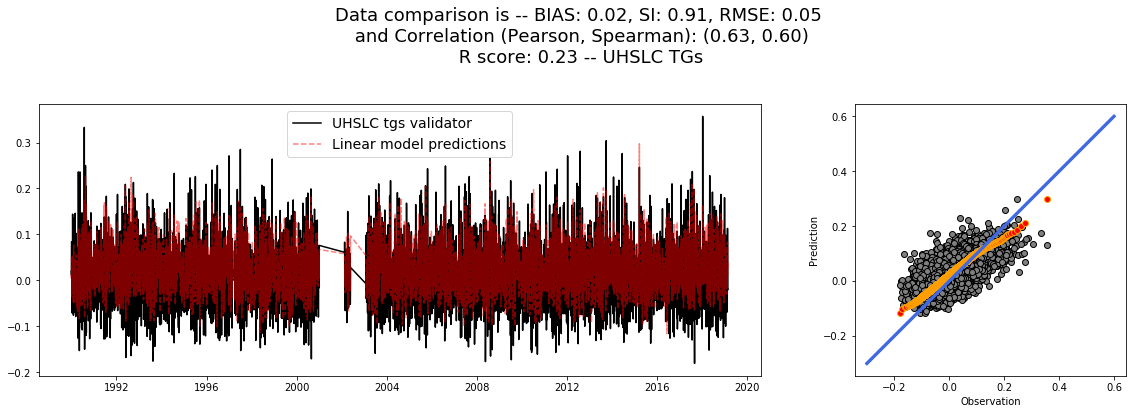


 72 PCs (0.9 expl. variance) will be used to train the model!! 



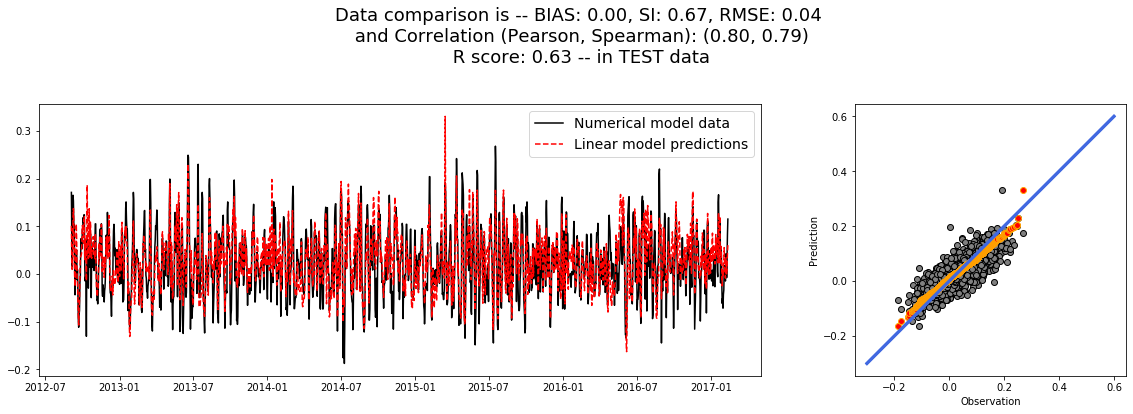

Data comparison is -- BIAS: 0.00, SI: 0.67, RMSE: 0.04
 and Correlation (Pearson, Spearman): (0.80, 0.79)
 R score: 0.63 -- in TEST data


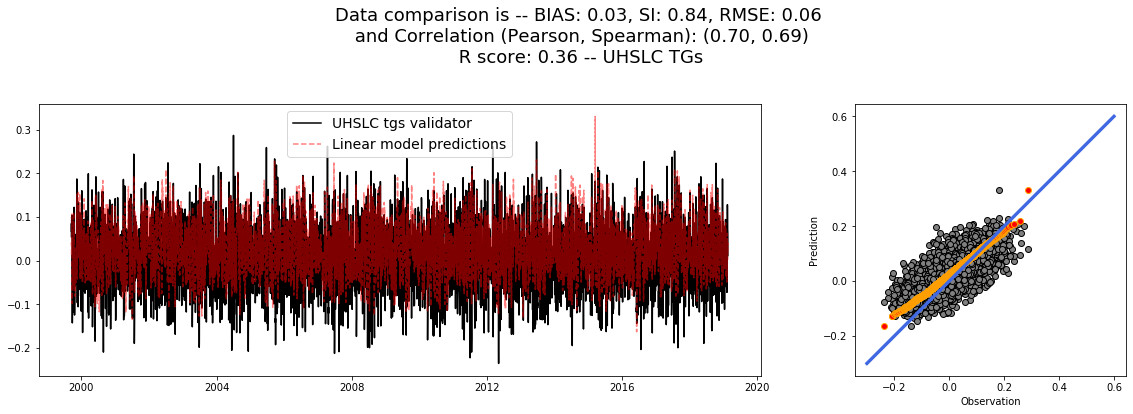


 72 PCs (0.9 expl. variance) will be used to train the model!! 



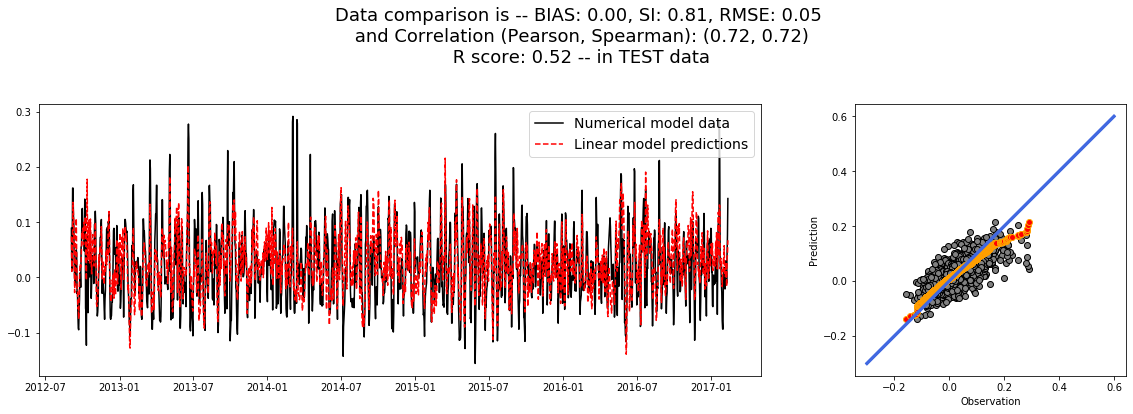

Data comparison is -- BIAS: 0.00, SI: 0.81, RMSE: 0.05
 and Correlation (Pearson, Spearman): (0.72, 0.72)
 R score: 0.52 -- in TEST data


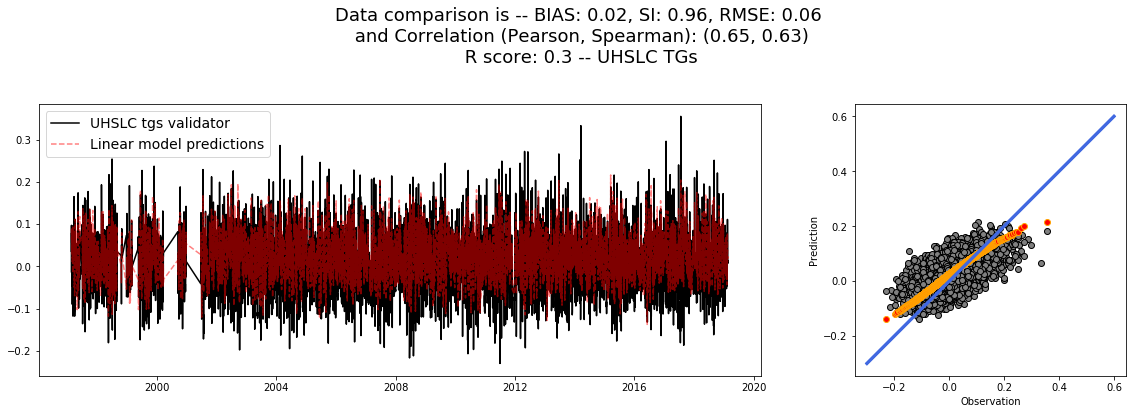

In [7]:
# validate model with tgs
stats = []
# select sites and append closest to UHSLC tgs
clos_to_uhslc = [689, 328, 393, 1327, 393, 480, 999, 116, 224, 1124, 949, 708]
for istat,stat in enumerate(clos_to_uhslc):
    ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
        .load().resample(time='1D').max()
    stats_stat = MultiLinear_Regression(
        pcs_cfsr, ss_moana, validator=(
            True,load_cfsr_moana_uhslc.validator.isel(name=istat),'ss'
        ), plot_results=True 
    )
    stats.append(stats_stat)

## linear regression with local predictor

In [8]:
run = False
if run:
    # perform the Multilinear-Regression (local)
    stats_local = []
    sites_local = np.arange(
        0,len(load_cfsr_moana_uhslc.predictand.site.values),10
    )
    for stat in progressbar.progressbar(sites_local):
        ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
            .load().resample(time='1D').max()
        stats_stat = MultiLinear_Regression(
            PCA_DynamicPred(
                load_cfsr_moana_uhslc.predictor_slp, 
                calculate_gradient=True, time_lapse=2,
                region=(True, (
                    ss_moana.lon.values[0]-2.1,
                    ss_moana.lon.values[0]+2.1,
                    ss_moana.lat.values[0]+2.1,
                    ss_moana.lat.values[0]-2.1
                )),
                pca_plot=False, verbose=False
            )[0],
            ss_moana, # tidal gauge (moana v2)
            verbose=False
        )
        stats_local.append(stats_stat)
    # save the statistics
    stats_local = xr.Dataset(
        data_vars={
            'bias':(('station'),np.array(stats_local)[:,0]),
            'si':(('station'),np.array(stats_local)[:,1]),
            'rmse':(('station'),np.array(stats_local)[:,2]),
            'pearson':(('station'),np.array(stats_local)[:,3]),
            'spearman':(('station'),np.array(stats_local)[:,4]),
            'rscore':(('station'),np.array(stats_local)[:,5]),
            'latitude':(('station'),
                load_cfsr_moana_uhslc.predictand.sel(site=sites_local).lat),
            'longitude':(('station'),
                load_cfsr_moana_uhslc.predictand.sel(site=sites_local).lon)
        },
        coords={
            'station': sites_local
        }
    )
    # local copy
    if True:
        stats_local.to_netcdf(data_path+'/statistics/stats_lm_local_daily.nc')
else:
    stats_local = xr.open_dataset(
        data_path+'/statistics/stats_lm_local_daily.nc'
    )

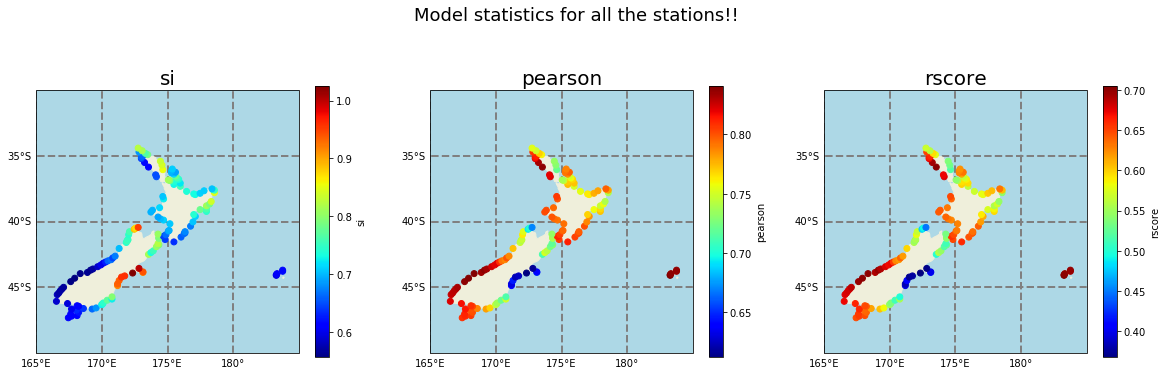

In [9]:
# plot results
if True:
    from sscode.plotting.validation import plot_stats
    plot_stats(stats_local,plot_stats=['si','pearson','rscore'])